In [1]:
import numpy as np 
import multiprocessing
import healpy as hp
from tqdm import tqdm 
import pandas as pd
threads = 10
NSIDE = 32
Npix = hp.nside2npix(NSIDE)
def load_cat_by_pix(pix):
    loaded_pix = pd.read_csv('/data/wiay/federico/PhD/cosmoflow/COSMOFlow/pixelated_catalogs/GLADE+_pix_NSIDE_{}/pixel_{}'.format(NSIDE,pix))
    #loaded_pix = loaded_pix.dropna()
    return loaded_pix

with multiprocessing.Pool(threads) as p:
    catalog_pixelated = list(tqdm(p.imap(load_cat_by_pix,np.arange(Npix)), total = Npix, desc = 'Loading mth map, NSIDE = {}'.format(NSIDE)))

Loading mth map, NSIDE = 32: 100%|██████████████████████████████████████████████| 12288/12288 [00:06<00:00, 1842.31it/s]


In [2]:
map_mth = np.loadtxt('/data/wiay/federico/PhD/cosmoflow/COSMOFlow/magnitude_threshold_maps/NSIDE_{}_mth_map_GLADE_{}.txt'.format(NSIDE,'K'))

In [15]:
z, z_err = [], []
for i in tqdm(range(Npix)):
    pixel = catalog_pixelated[i].dropna()
    z.append(np.array(pixel.z))
    z_err.append(np.array(pixel.sigmaz))
z = np.concatenate(z)
z_err = np.concatenate(z_err)
    

# catalog_pixelated[0]

100%|███████████████████████████████████████████████████████████████████████████| 12288/12288 [00:06<00:00, 1998.37it/s]


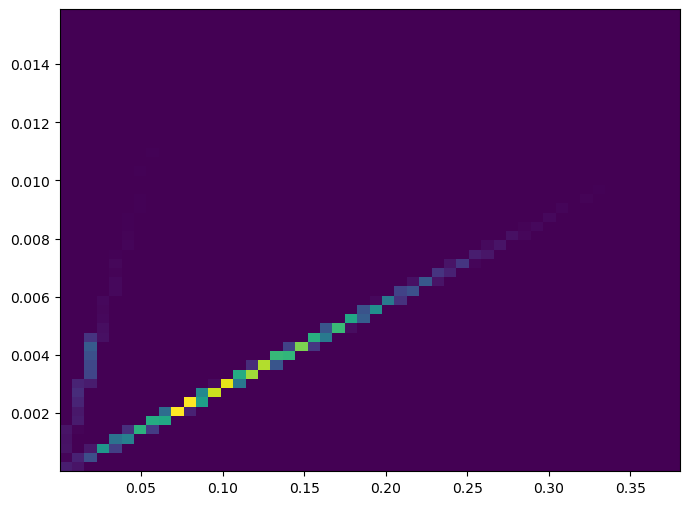

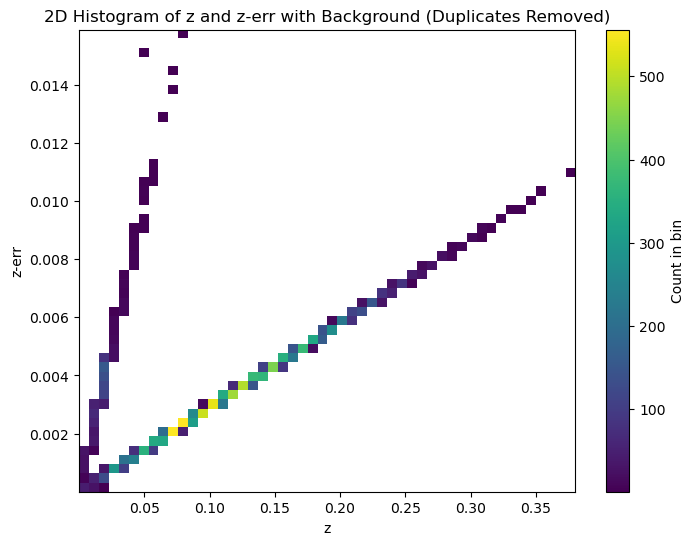

In [17]:
import numpy as np
import matplotlib.pyplot as plt


# Create a 2D histogram
plt.figure(figsize=(8, 6))
# Identify unique values in z_err and their indices
unique_z_err, indices = np.unique(z_err, return_index=True)

# Filter z values to match unique z_err values
unique_z = z[indices]

# Create a 2D histogram
counts, xedges, yedges, _ = plt.hist2d(unique_z, unique_z_err, bins=50, cmap='viridis')

# Replace zero counts with NaN
counts[counts == 0] = np.nan

plt.figure(figsize=(8, 6))
# Using imshow to plot the array with NaN values shown as background
plt.imshow(counts.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='viridis', aspect='auto')

# Add a color bar
plt.colorbar(label='Count in bin')

# Add labels and title
plt.xlabel('z')
plt.ylabel('z-err')
plt.title('2D Histogram of z and z-err with Background (Duplicates Removed)')

# Show the plot
plt.show()

In [3]:
# loaded_pixel = catalog_pixelated[363][['z','RA','dec', 'sigmaz', 'm'+band]]
# loaded_pixel = loaded_pixel[loaded_pixel['m'+band] < map_mth[362]]
# loaded_pixel = loaded_pixel.dropna()
# loaded_pixel

In [4]:
# np.array(catalog_pixelated[362].dropna().z)

In [32]:
nside = 8
pixel_index = np.random.randint(hp.nside2npix(nside))
# Get the theta and phi coordinates of the pixel center
theta, phi = hp.pix2ang(nside, pixel_index)

# Convert to RA and Dec
ra_center = np.degrees(phi)
dec_center = 90 - np.degrees(theta)  # Declination is 90 degrees - theta in degrees

# Get the approximate size of the pixel in radians
pixel_size = np.sqrt(hp.nside2pixarea(nside))

# To sample uniformly within the pixel, you might use a small square approximation
# Here's a simple way to uniformly sample within the pixel bounds:
num_samples = 100  # Number of samples you want

# Create random offsets from the pixel center, scaled by the pixel size
# Ensure the offsets are small enough to be within the pixel boundaries
# We use (pixel_size / np.sqrt(2)) to approximate a square around the center
offsets_theta = (np.random.rand(num_samples) - 0.5) * (pixel_size / np.sqrt(2))
offsets_phi = (np.random.rand(num_samples) - 0.5) * (pixel_size / np.sqrt(2))

# Calculate the sample coordinates
sample_thetas = theta + offsets_theta
sample_phis = phi + offsets_phi

# Convert to RA and Dec
sample_ras = np.deg2rad(np.degrees(sample_phis))
sample_decs = np.deg2rad(90 - np.degrees(sample_thetas))

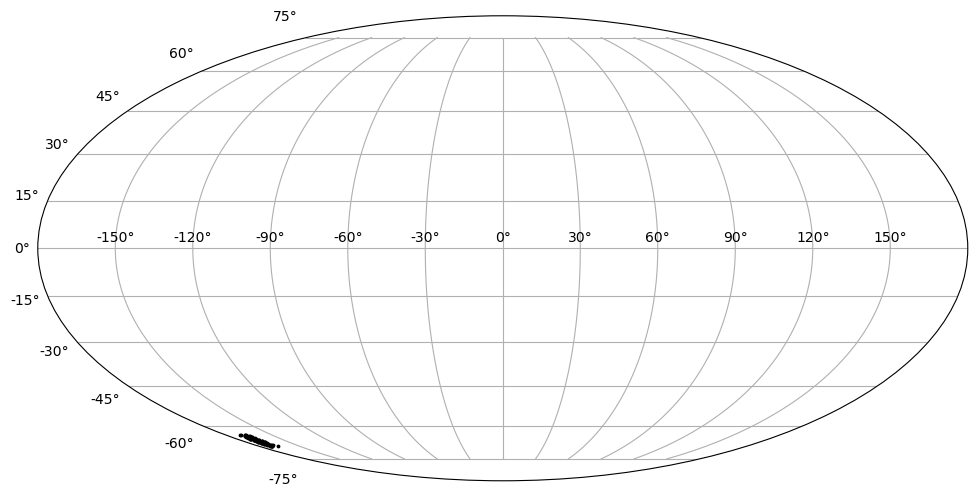

In [33]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection="mollweide")
ax.grid(True)
scin = ax.scatter(np.pi - np.array(sample_ras)  ,   np.array(sample_decs) , s = 3, c='black', alpha = 1)
plt.show()

In [8]:
# import os 
# os.chdir('..')
# from cosmology_functions import cosmology

Npix_tot = hp.nside2npix(NSIDE)
weight_pixel = np.zeros(Npix_tot)
band = 'K'
H0 = 70
# pixel = 0

weights = [] 
for pixel in tqdm(range(Npix_tot)):
    loaded_pixel = catalog_pixelated[pixel]
    
    loaded_pixel = loaded_pixel[['z','RA','dec', 'sigmaz', 'm'+band]] #load pixel 
    loaded_pixel = loaded_pixel.dropna() # drop any Nan values 
    mth = map_mth[pixel]
    loaded_pixel = loaded_pixel[loaded_pixel.z > 0]
    loaded_pixel = loaded_pixel[loaded_pixel['m'+band] < mth]
    
    if len(loaded_pixel) > 2:
    # temporary_zmax = z_class.zmax_H0(H0, SNRth) #for compelteness use the zmax at the given H0 

        loaded_pixel = loaded_pixel[loaded_pixel.z <= 1.6] #check if redshift is less than zmax at H0 value
        loaded_pixel = loaded_pixel[loaded_pixel.z >= 0.0] #check if z is greater than zmin 
        loaded_pixel['RA'] = np.deg2rad(loaded_pixel['RA']) #convert RA and dec into radians 
        loaded_pixel['dec'] = np.deg2rad(loaded_pixel['dec'])

        Ngalpix = len(loaded_pixel) #get number of galaxies in pixel 
        z_gal_selected = loaded_pixel.z #get redshift 
        repeated_H0_in_pix = H0 #for that specific pixel, make vector of H0s used for the specific pixel 

        dl_galaxies = cosmology.fast_z_to_dl_v2(np.array(z_gal_selected).flatten(),np.array(repeated_H0_in_pix).flatten()) #compute distances of galaxies using redshift and H0 

        #get luminsoity
        # print(loaded_pixel['m'+band],dl_galaxies)
        absolute_mag = cosmology.abs_M(loaded_pixel['m'+band],dl_galaxies)
        luminosities =  cosmology.mag2lum(absolute_mag)
        luminosities = np.nan_to_num(luminosities)
        
        weight_pixel[pixel]=(np.sum(luminosities))
        weights.append(luminosities)



100%|████████████████████████████████████████████████████████████████████| 12288/12288 [00:38<00:00, 321.74it/s]


In [9]:
# weights = np.concatenate(weights)
weighted_weights = weights 


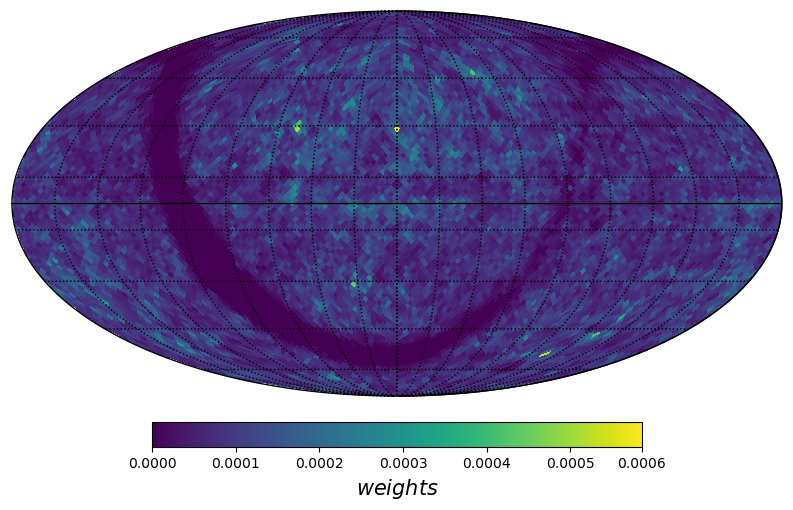

In [10]:
import healpy as hp
import matplotlib.pyplot as plt
NSIDE = 64
weight_pixelMAP = np.array(weight_pixel) / np.sum(np.array(weight_pixel) )

map_Glade = hp.mollview(weight_pixelMAP  ,title = '', rot = (180,0,0),  cbar=None)
hp.graticule(True)

fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cmap = fig.colorbar(image, ax=ax, orientation = 'horizontal', shrink = 0.6, location='bottom', pad=0.05)
cmap.set_label( label=r'$weights$', fontsize = 15)
# plt.savefig('GLADE+_map.png', dpi = 500)
plt.show()

In [23]:
weight_pixel/np.sum(weight_pixel)

array([8.77070210e-05, 1.10830371e-04, 1.18315659e-04, ...,
       7.06582076e-05, 7.52820261e-05, 7.66318881e-05])

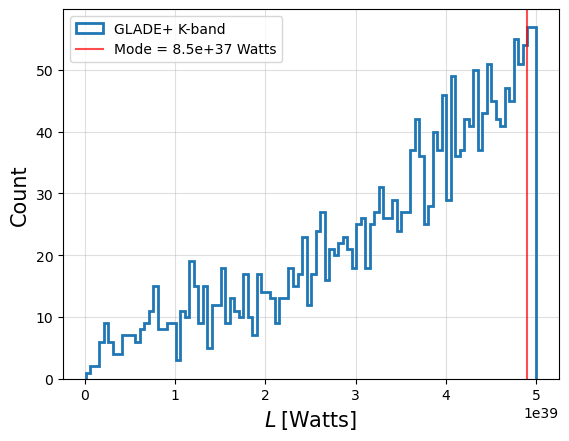

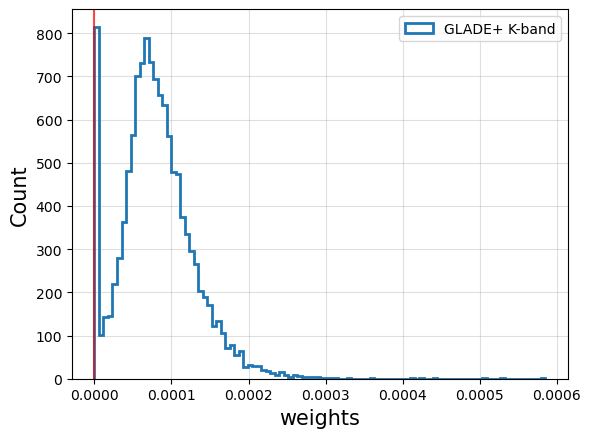

In [21]:
import matplotlib.pyplot as plt
hist = plt.hist(weight_pixel, bins = 100, histtype = 'step', range = (1e37, 5e39), linewidth = 2, label = 'GLADE+ K-band')
# plt.xscale('log')
maximum = np.where(hist[0] == np.max(hist[0]))[0][0]
mean = np.mean(weight_pixel)
# plt.yscale('log')
plt.xlabel(r'$L \: $[Watts]', fontsize = 15)
plt.ylabel(r'Count', fontsize = 15)
plt.axvline(x = hist[1][maximum],alpha = 0.7, color = 'red', label = 'Mode = {} Watts'.format(8.5e37))
plt.legend(loc = 'upper left', fontsize = 10)
plt.grid(True, alpha = 0.4)
plt.show()


hist = plt.hist(weight_pixel/np.sum(weight_pixel), bins = 100, histtype = 'step', linewidth = 2, label = 'GLADE+ K-band')
# plt.xscale('log')
maximum = np.where(hist[0] == np.max(hist[0]))[0][0]
mean = np.mean(weight_pixel/np.sum(weight_pixel))
# plt.yscale('log')
plt.xlabel(r'weights', fontsize = 15)
plt.ylabel(r'Count', fontsize = 15)
plt.axvline(x = hist[1][maximum],alpha = 0.7, color = 'red')
plt.legend(loc = 'upper right', fontsize = 10)
plt.grid(True, alpha = 0.4)
plt.show()

In [80]:
catalog_pixelated[71042][['RA','dec','mK','z','sigmaz']]

,RA,dec,mK,z,sigmaz
0,91.306343,15.817182,14.03,NaN,NaN
1,91.314156,16.224403,14.25,0.0,0.00015


In [8]:
n_empty = 0
for i in tqdm(range(196608)):
    if catalog_pixelated[i].empty is False:
        n_empty += 1
        # avg_N.append(len(catalog_pixelated[i]))
    # if catalog_pixelated[i].empty is True:
    #     print(i)


100%|███████████████████████████████████████████████████████████████████████| 196608/196608 [00:00<00:00, 305765.75it/s]


In [9]:
n_empty

187938

In [1]:
import os 
os.chdir('..')
from cosmology_functions import cosmology
from cosmology_functions import utilities
def load_pixel(pix): #load pixel from catalog
    loaded_pix = catalog_pixelated[pix]
    return loaded_pix, len(loaded_pix)

In [85]:
band = 'K'
def select_gal_from_pix(pixels_H0_gamma_para): 
    # "Selects galaxies from pixel using pixel index and associated H0 to pixel"
    # "Input: tuple(pixel_inx,H0); 
    # "Returns: dataframe of pixel id (z, ra, dec...)" 
    
    pixel, H0 = pixels_H0_gamma_para
    loaded_pixel, Ngalpix = load_pixel(int(pixel)) ############# PROBLEM HERE
    loaded_pixel = loaded_pixel[['z','RA','dec', 'sigmaz', 'm'+band]] #load pixel 
    loaded_pixel = loaded_pixel.dropna() # drop any Nan values 
    
    # temporary_zmax = z_class.zmax_H0(H0, SNRth) #for compelteness use the zmax at the given H0 
    
    loaded_pixel = loaded_pixel[loaded_pixel.z <= 1.0] #check if redshift is less than zmax at H0 value
    loaded_pixel = loaded_pixel[loaded_pixel.z >= 0.0] #check if z is greater than zmin 
    loaded_pixel['RA'] = np.deg2rad(loaded_pixel['RA']) #convert RA and dec into radians 
    loaded_pixel['dec'] = np.deg2rad(loaded_pixel['dec'])

    Ngalpix = len(loaded_pixel) #get number of galaxies in pixel 
    
    if loaded_pixel.empty is False: #if there are galaxies in the pixel
        z_gal_selected = loaded_pixel.z #get redshift 
        repeated_H0_in_pix = np.ones(Ngalpix)*H0 #for that specific pixel, make vector of H0s used for the specific pixel 
        
        dl_galaxies = cosmology.fast_z_to_dl_v2(np.array(z_gal_selected).flatten(),np.array(repeated_H0_in_pix).flatten()) #compute distances of galaxies using redshift and H0 
        
        
        #get luminsoity
        # print(loaded_pixel['m'+band],dl_galaxies)
        absolute_mag = cosmology.abs_M(loaded_pixel['m'+band],dl_galaxies)
        luminosities =  cosmology.mag2lum(absolute_mag)
        # print(dl_galaxies, z_gal_selected)
        
        #weights = L * madau(z) * (1/(1+z))
        weights_gal = luminosities #* z_class.time_z(z_gal_selected) #* z_class.Madau_factor(z_gal_selected, zp, gamma, k) 
        # print(luminosities)
        weights_gal = np.nan_to_num(weights_gal)
         # check weights sum to 1
        if np.sum(weights_gal) == 0.0:
            print(weights_gal, luminosities, absolute_mag, dl_galaxies, pixel)
        weights_gal /= np.sum(weights_gal)
        gal_id = np.random.choice(np.arange(Ngalpix), size = 1, p = weights_gal) #random choice of galaxy in the pixel 
        return loaded_pixel.iloc[gal_id,:]
    
    else: #if no galaxies in pixel, return None Total for federico: 1 jobs; 0 completed, 0 removed, 1 idle
        return None 

In [90]:
N = 100000
RA, dec = cosmology.draw_RA_Dec(N)
H0s = np.random.uniform(20,140,N)
app_samples = np.random.uniform(14.16,14.17,N)

mth_list = np.array([utilities.mth_from_RAdec(NSIDE, RA, dec, map_mth)]).flatten() #list of mths 
pix_list = np.array([utilities.pix_from_RAdec(NSIDE, RA, dec)]).flatten() #list of pixels per mth
inx_in_gal = np.where((app_samples < mth_list) == True)[0]

# pixels = np.random.randint(0,196608, 100)
# pixels = 137725*np.ones(len(inx_in_gal))
pixels = pix_list[inx_in_gal]
H0s = H0s[inx_in_gal]
pixel_H0 = np.array([pixels, H0s]).T

In [ ]:
len(pixels)

In [37]:
np.where((app_samples < mth_list) == True)[0]

array([   1,    2,    3, ..., 9991, 9998, 9999])

In [91]:
import multiprocessing
with multiprocessing.Pool(10) as p: #multiprocess for galaxy pixel loading 
    selected_cat_pixels = list(p.imap(select_gal_from_pix,pixel_H0))

In [ ]:
len(selected_cat_pixels)

In [51]:
selected_cat_pixels#[int(1.81190000e+05)]

[          z        RA       dec  sigmaz         mK
 1  0.166705  1.277166  0.167143   0.015  14.381766,
            z        RA       dec  sigmaz         mK
 18  0.110852  2.924352  0.899403   0.015  14.631938,
           z        RA       dec  sigmaz         mK
 17  0.21654  3.592207  0.751901   0.015  14.484759,
             z        RA       dec    sigmaz      mK
 125  0.813381  3.338591  0.677393  0.059842  15.834,
            z        RA       dec  sigmaz         mK
 15  0.217424  3.245238  0.247178   0.015  14.569652,
           z        RA       dec   sigmaz         mK
 20  0.20069  2.613056  0.538861  0.00582  14.272585,
           z        RA       dec  sigmaz      mK
 15  0.31464  2.721366  0.479431   0.015  14.335,
           z        RA       dec  sigmaz         mK
 0  0.157258  0.205386  0.798525   0.015  14.264581,
             z        RA       dec   sigmaz      mK
 116  0.264839  0.838427 -0.142602  0.04174  14.168,
            z        RA       dec  sigmaz         mK


In [41]:
selected_cat_pixels.index(None)

# na_indices = selected_cat_pixels[selected_cat_pixels.isna().any(axis=1)].index

# print("Indices with None/NaN:", na_indices)

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [11]:
# 7086  8847  6366 10346  8782  4553  6918  8319  7884 10147
loaded_pixel = catalog_pixelated[10]
loaded_pixel = loaded_pixel[['z','RA','dec', 'sigmaz', 'm'+'K']]
loaded_pixel = loaded_pixel[loaded_pixel.z <= 1]
loaded_pixel = loaded_pixel[loaded_pixel.z >= 0.001]
loaded_pixel['RA'] = np.deg2rad(loaded_pixel['RA'])
loaded_pixel['dec'] = np.deg2rad(loaded_pixel['dec'])
loaded_pixel = loaded_pixel.dropna()
Ngalpix = len(loaded_pixel)
print(Ngalpix)

56


In [27]:
3.44 - 5*np.log(0.765) - 25

-20.220602774221994

49.94266012197743


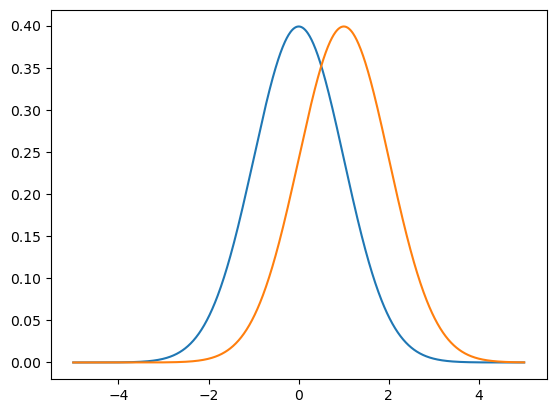

In [69]:
from scipy.stats import norm
import matplotlib.pyplot as plt


x = np.linspace(-5, 5, 1000)
pdf_1 = norm.pdf(x, loc = 0, scale = 1)
pdf_2 = norm.pdf(x, loc = 1, scale = 1)


def KL_distance(p,q):
    return sum(p*np.log(p/q))

def JS_distance(p,q):
    return (KL_distance(p,q) + KL_distance(q,p))/2
    


plt.plot(x, pdf_1)
plt.plot(x, pdf_2)
print(JS_distance(pdf_1, pdf_2))
plt.show()


In [75]:
cosmo = cosmology.FlatLambdaCDM(H0 = 70, Om0 = 0.275)
dl = cosmo.luminosity_distance(1).value
print(dl)

6708.650932809531


In [46]:
from astropy import cosmology 




def M_mzH(m,z,H):
    cosmo = cosmology.FlatLambdaCDM(H0 = H, Om0 = 0.278)
    dl = cosmo.luminosity_distance(z).value
    print(dl)
    return m - 5*np.log(dl) - 25


M_mzH(13.32,0.00972 ,70)

41.947561880737176


-30.36210155787753

In [8]:
cat =pd.concat(catalog_pixelated, ignore_index = False)
cat = cat[['z','RA','dec', 'sigmaz', 'm'+'K']]
cat = cat.dropna()

/tmp/ipykernel_3470839/3816499505.py:30: RuntimeWarning: divide by zero encountered in log10
  map_Glade = hp.mollview(np.log10(bc*mask),title = '', rot = (180,0,0),  cbar=None)


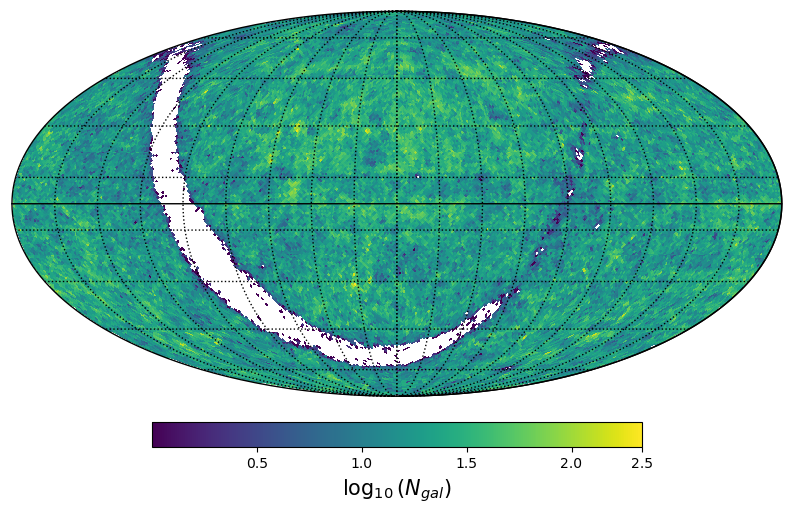

In [47]:
import healpy as hp
import matplotlib.pyplot as plt
NSIDE = 64

#Spherical Angles
phis = np.array(np.deg2rad(cat.RA))
thetas = np.pi/2 - np.array(np.deg2rad(cat.dec))
positive_indicies = np.where(phis > 0)[0]
phis = phis[positive_indicies]
thetas = thetas[positive_indicies]

#Turn angles into pixel indicies
pixel_indices = hp.ang2pix(NSIDE, thetas, phis, nest = False)
 
#Tot number of pixels 
Npix = hp.nside2npix(NSIDE)
    
#count indiceis in bins, (galaxy count per pixel)
bc = np.bincount(pixel_indices, minlength=Npix)


#initialise zeros mask
mask = np.zeros(Npix, dtype = int) #Blank healpix map

#N galaxies Threshold 
Nth = 1
inx = np.where((bc >= Nth))
mask[inx] = 1

map_Glade = hp.mollview(np.log10(bc*mask),title = '', rot = (180,0,0),  cbar=None)
hp.graticule(True)

fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]


cmap = fig.colorbar(image, ax=ax, orientation = 'horizontal', ticks = [0.5, 1, 1.5, 2, 2.5], shrink = 0.6, location='bottom', pad=0.05)
cmap.set_label( label=r'$\log_{10}(N_{gal})$', fontsize = 15)
# plt.savefig('GLADE+_map.png', dpi = 500)
plt.show()

In [50]:
np.sum(mask) / 49152

0.9442545572916666

In [49]:
hp.nside2npix(64)

49152

In [14]:
import numpy as np 
import multiprocessing
import healpy as hp
from tqdm import tqdm 
import pandas as pd


# Define the NSIDE values
nside_high = 128  # High resolution
nside_low = 32    # Low resolution

# Number of pixels at each resolution
npix_high = hp.nside2npix(nside_high)
npix_low = hp.nside2npix(nside_low)

# Creating a dummy map for demonstration (you would use your actual map here)
high_res_map_128 = range(npix_high)  # For example, pixel indices as values
low_res_map_32 = range(npix_low)

# Degrading the resolution
high_res_map_32 = hp.pixelfunc.ud_grade(low_res_map, nside_out=nside_high, order_in='NESTED', order_out='NESTED')

# low_res_map now contains the values associated with each pixel at the lower resolution



In [5]:
import os 
os.chdir('..')
from cosmology_functions import cosmology

In [11]:
ra,dec = cosmology.draw_RA_Dec(10)
pixels_128 = cosmology.pix_from_RAdec(128, ra, dec)

pixels_32 = hp.pixelfunc.ud_grade(pixels_128, nside_out=32, order_in='NESTED', order_out='NESTED')

print(pixels_32,pixels_128)



TypeError: bad number of pixels

In [13]:
def change_resolution(NSIDE_high, NSIDE_low, pixels, type_of_change = 'upgrade', order = 'NESTED'):
    npix_high = hp.nside2npix(nside_high)
    npix_low = hp.nside2npix(nside_low)
    high_res_map = range(npix_high) 
    low_res_map = range(npix_low)
    if type_of_cahnge == 'upgrade':
        
        

array([    0,     0,     0, ..., 12287, 12287, 12287])

In [51]:
import pandas as pd
import multiprocessing 
import healpy as hp
from tqdm import tqdm 
import numpy as np
import matplotlib.pyplot as plt

band = 'K'

NSIDE = 32
Npix = hp.nside2npix(NSIDE)

def mth_per_pixel(pix):
    loaded_pix = pd.read_csv('/data/wiay/federico/PhD/cosmoflow/COSMOFlow/pixelated_catalogs/GLADE+_pix_NSIDE_{}/pixel_{}'.format(NSIDE,pix))
    
    loaded_pix = loaded_pix[['RA', 'dec', 'm'+band, 'z', 'sigmaz' ]]
    loaded_pix.replace(0, np.nan, inplace=True)
    loaded_pix = loaded_pix.dropna()
    Npix = len(loaded_pix)
    magnitudes = loaded_pix['m'+band]
    if (len(magnitudes) >= 1) and ( np.sum(loaded_pix.z) >= 0 ): 
        mag = np.median(magnitudes)
    else: 
        mag = 0
    
    return mag

with multiprocessing.Pool(10) as p:
    map_mth = list(tqdm(p.imap(mth_per_pixel,np.arange(Npix)), total = Npix))
    
# np.savetxt('/data/wiay/federico/PhD/cosmoflow/COSMOFlow/magnitude_threshold_maps/NSIDE_'+str(NSIDE)+'_mth_map_GLADE_'+band+'.txt', map_mth)
    
    


100%|██████████| 12288/12288 [00:05<00:00, 2057.92it/s]


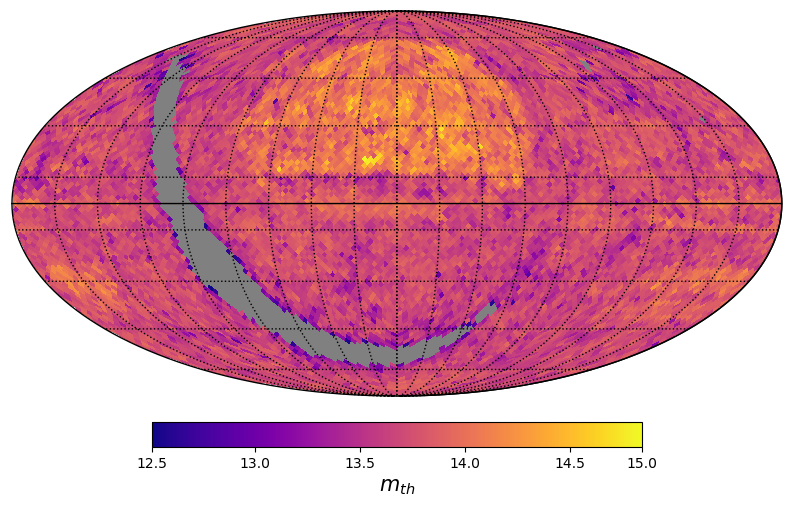

In [64]:
map_mth = np.array(map_mth)

inx_low = np.where(map_mth < 12.5)
    
map_mth[inx_low] = np.nan
    
hp.mollview(np.array(map_mth) , rot = (180,0,0), cbar = None, title = '', cmap = 'plasma')
hp.graticule(True)
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]

cmap = fig.colorbar(image, ax=ax, orientation = 'horizontal', ticks = [12.5, 13.0, 13.5, 14.0, 14.5, 15.0], shrink = 0.6, location='bottom', pad=0.05)
cmap.set_label( label=r'$m_{th}$', fontsize = 15)
plt.savefig('../pixelated_catalogs/GLADE+_map_K_mth_32.png', dpi = 500)
plt.show()
